In [19]:
from google.colab import drive
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier


In [23]:
# Cargar el dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/modelos2/Occupancy_Estimation.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Número de componentes seleccionados: {pca.n_components_}")

Número de componentes seleccionados: 10


In [15]:


cv = TimeSeriesSplit(n_splits=5)
folds = list(cv.split(X_pca))

# Asegurar que haya todas las clases en test

clases_requeridas = set(np.unique(y))
selected_fold = None

for train_idx, test_idx in reversed(folds):
    y_test_fold = y.iloc[test_idx]
    clases_en_test = set(np.unique(y_test_fold))
    if clases_requeridas.issubset(clases_en_test):
        selected_fold = (train_idx, test_idx)
        break

train_idx, test_idx = selected_fold
X_train, X_test = X_pca[train_idx], X_pca[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [20]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:15:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
# Métricas para Random Forest
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# Métricas para XGBoost
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

# Mostrar resultados
print(f"🔹 Random Forest - Accuracy: {acc_rf:.4f}, F1-score (macro): {f1_rf:.4f}")
print(f"🔹 XGBoost       - Accuracy: {acc_xgb:.4f}, F1-score (macro): {f1_xgb:.4f}")


🔹 Random Forest - Accuracy: 0.9799, F1-score (macro): 0.9228
🔹 XGBoost       - Accuracy: 0.9348, F1-score (macro): 0.7865


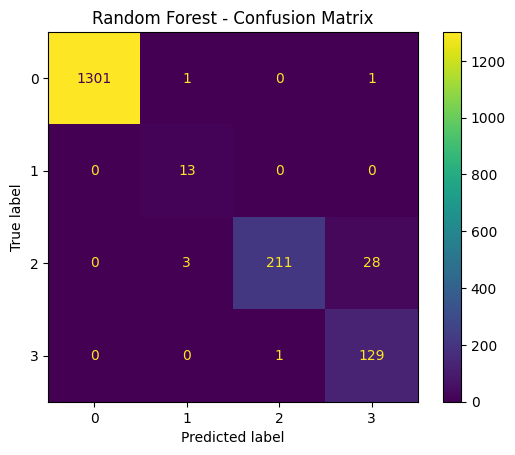

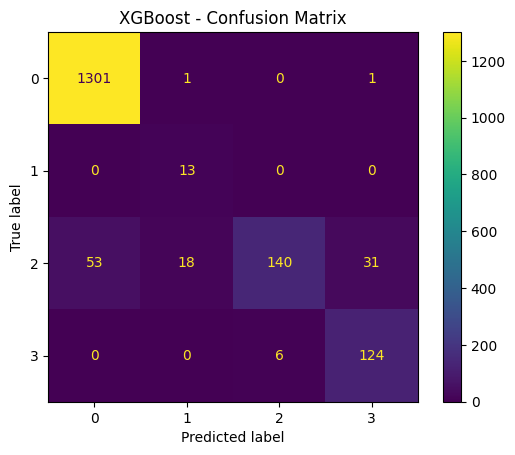

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Random Forest
disp_rf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
disp_rf.ax_.set_title("Random Forest - Confusion Matrix")

# XGBoost
disp_xgb = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
disp_xgb.ax_.set_title("XGBoost - Confusion Matrix")

plt.show()
